In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

PATH_TO_DATA = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
data = pd.read_csv(PATH_TO_DATA, header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [4]:
features = data.drop(140, axis = 1)
target = data[140]
xtrain, xtest, ytrain, ytest = train_test_split(features, target, test_size = 0.2, stratify=target)
train_index = ytrain[ytrain == 1].index
train_data = xtrain.loc[train_index]

In [14]:
minmaxscalar = MinMaxScaler(feature_range=(0,1))
x_train_scaled = minmaxscalar.fit_transform(train_data.copy()) 
x_test_scaled = minmaxscalar.transform(xtest.copy())

In [15]:
class Autoencoder(Model):
    def __init__(self, output_units, ldem = 8):
        super().__init__()
        self.endcoder = Sequential([
            Dense(64, activation = "relu"),
            Dropout(0.1),
            Dense(32, activation = "relu"),
            Dropout(0.1),
            Dense(16, activation = "relu"),
            Dropout(0.1),
            Dense(ldem, activation = "relu")
        ])
        self.decoder = Sequential([
            Dense(16, activation = "relu"),
            Dropout(0.1),
            Dense(32, activation = "relu"),
            Dropout(0.1),
            Dense(64, activation = "relu"),
            Dropout(0.1),
            Dense(output_units, activation = "sigmoid")
        ])
    def call(self, inputs):
        encoded = self.endcoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

In [16]:
model = Autoencoder(output_units = x_train_scaled.shape[1])
model.compile(loss = "msle", metrics = "mse", optimizer = 'adam')
epohs = 20

In [17]:
history = model.fit(x_train_scaled, x_train_scaled, batch_size = 512, epochs=epohs, validation_data=(x_test_split, x_test_split))

Epoch 1/20
5/5 [==============================] - 1s 67ms/step - loss: 0.0103 - mse: 0.0232 - val_loss: 0.0137 - val_mse: 0.0319
Epoch 2/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0099 - mse: 0.0223 - val_loss: 0.0134 - val_mse: 0.0313
Epoch 3/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0092 - mse: 0.0207 - val_loss: 0.0133 - val_mse: 0.0308
Epoch 4/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0084 - mse: 0.0188 - val_loss: 0.0131 - val_mse: 0.0303
Epoch 5/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0076 - mse: 0.0169 - val_loss: 0.0125 - val_mse: 0.0290
Epoch 6/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0068 - mse: 0.0151 - val_loss: 0.0121 - val_mse: 0.0281
Epoch 7/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0061 - mse: 0.0136 - val_loss: 0.0115 - val_mse: 0.0266
Epoch 8/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0057 - mse: 0.0126 - val

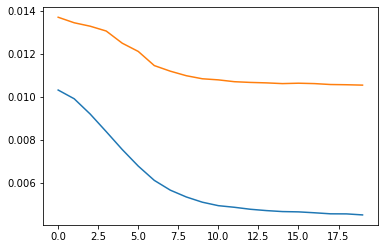

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [19]:
x = model.predict(x_train_scaled)
x_errors = tf.keras.losses.msle(x, x_train_scaled)
threshold = np.mean(x_errors.numpy()) + np.std(x_errors.numpy())
threshold

73/73 [==============================] - 0s 2ms/step


0.009817678477399755

In [23]:
x1 = model.predict(x_test_scaled)
x1_errors = tf.keras.losses.msle(x1, x_test_scaled)
anomaly_mask = pd.Series(x1_errors) > threshold
pred = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)

accuracy_score(pred, ytest)

32/32 [==============================] - 0s 2ms/step


0.937

In [24]:
distance_matrix = euclidean_distances(weights)

NameError: name 'euclidean_distances' is not defined

In [26]:
import sklearn.
distance_matrix = euclidean_distances(weights)

NameError: name 'euclidean_distances' is not defined